In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("transactions.csv")

In [3]:
#Device Determination
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

#Column Definition
TARGET_COL = 'is_fraud'

NUMERICAL_COLS = [
    'account_age_days', 'total_transactions_user', 'avg_amount_user', 
    'amount', 'shipping_distance_km'
]
BINARY_ORDINAL_COLS = [
    'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag'
]
CATEGORICAL_COLS = [
    'country', 'bin_country', 'channel', 'merchant_category'
]
# --- Minimum Features Engineering for 'transaction_time' ---
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['transaction_hour'] = df['transaction_time'].dt.hour
NUMERICAL_COLS.append('transaction_hour') 
# Note: Implement this if you want to use the time column.
ALL_FEATURES = NUMERICAL_COLS + BINARY_ORDINAL_COLS + CATEGORICAL_COLS

Usando dispositivo: cuda


In [4]:
# Separation of X and y
X = df[ALL_FEATURES].copy()
y = df[TARGET_COL].values

# Data division
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
pytorch_cat_mappers = {}
X_train_cat_encoded = X_train[CATEGORICAL_COLS].copy()
X_test_cat_encoded = X_test[CATEGORICAL_COLS].copy()

for col in CATEGORICAL_COLS:
    le = LabelEncoder()
    # Adjust ONLY in training and transform both sets
    X_train_cat_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_cat_encoded[col] = le.transform(X_test[col].astype(str))
    pytorch_cat_mappers[col] = (len(le.classes_), le) # Guardamos la cardinalidad

# Standardization of Numericals
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[NUMERICAL_COLS + BINARY_ORDINAL_COLS])
X_test_num = scaler.transform(X_test[NUMERICAL_COLS + BINARY_ORDINAL_COLS])

# Final Data for PyTorch
X_train_num_pt = X_train_num
X_test_num_pt = X_test_num
X_train_cat_pt = X_train_cat_encoded.values
X_test_cat_pt = X_test_cat_encoded.values

In [6]:
# --- Definition of embedding dimensions ---
# We determine the dimensions of the embedding vector (e.g., min(50, cardinality // 2)
embedding_dims = []
for col in CATEGORICAL_COLS:
    cardinality = pytorch_cat_mappers[col][0]
    embed_dim = min(50, (cardinality + 1) // 2) 
    embedding_dims.append((cardinality, embed_dim))

In [7]:
# --- 2. DATASET, DATALOADER AND PYTORCH MODEL---

class FraudDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

In [8]:
class FraudClassifier(nn.Module):
    def __init__(self, num_numerical_cols, embedding_dims, num_hidden_units=128):
        super().__init__()
        self.embedding_layers = nn.ModuleList([nn.Embedding(num_unique, dim) for num_unique, dim in embedding_dims])
        total_embed_size = sum([dim for num_unique, dim in embedding_dims])
        total_input_size = num_numerical_cols + total_embed_size
        
        self.fc1 = nn.Linear(total_input_size, num_hidden_units)
        self.bn1 = nn.BatchNorm1d(num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_hidden_units // 2)
        self.bn2 = nn.BatchNorm1d(num_hidden_units // 2)
        self.output_layer = nn.Linear(num_hidden_units // 2, 1)

    def forward(self, x_num, x_cat):
        x_embed = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embedding_layers)]
        x_all = torch.cat(x_embed + [x_num], dim=1)
        
        x = F.relu(self.bn1(self.fc1(x_all)))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.3, training=self.training)
        
        return self.output_layer(x)

# Creating Dataset and DataLoader Instances
train_dataset = FraudDataset(X_train_num_pt, X_train_cat_pt, y_train)
test_dataset = FraudDataset(X_test_num_pt, X_test_cat_pt, y_test)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate, move to device, and configure (CORRECT ORDER)
N_NUM_FEATURES = len(NUMERICAL_COLS) + len(BINARY_ORDINAL_COLS)
model = FraudClassifier(N_NUM_FEATURES, embedding_dims)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# --- PyTorch Training Loop ---
def train_pytorch_model(model, train_loader, criterion, optimizer, num_epochs=15):
    print("\n--- Training PyTorch FNN ---")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x_num, x_cat, labels in train_loader:
            x_num, x_cat, labels = x_num.to(device), x_cat.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_num, x_cat)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")

train_pytorch_model(model, train_loader, criterion, optimizer, num_epochs=15)


--- Entrenando PyTorch FNN ---
Epoch 5/15 | Loss: 0.0484
Epoch 10/15 | Loss: 0.0442
Epoch 15/15 | Loss: 0.0423


In [10]:
# Create the preprocessor for Sklearn (StandardScaler + OneHotEncoder)
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_COLS + BINARY_ORDINAL_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_COLS)
    ],
    remainder='passthrough'
)

# Apply preprocessing
X_train_sklearn = preprocessor_sklearn.fit_transform(X_train)
X_test_sklearn = preprocessor_sklearn.transform(X_test)

In [11]:
# A. Logistic Regression
lr_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
lr_model.fit(X_train_sklearn, y_train)
lr_probs = lr_model.predict_proba(X_test_sklearn)[:, 1]
print("\n--- Training Logistic Regression --- Done.")

# B. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10, n_jobs=-1)
rf_model.fit(X_train_sklearn, y_train)
rf_probs = rf_model.predict_proba(X_test_sklearn)[:, 1]
print("--- Training Random Forest --- Done.")


--- Entrenando Regresión Logística --- Listo.
--- Entrenando Random Forest --- Listo.


In [12]:
def get_pytorch_probs(model, data_loader):
    model.eval()
    all_preds_prob = []
    with torch.no_grad():
        for x_num, x_cat, _ in data_loader:
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            outputs = model(x_num, x_cat)
            probabilities = torch.sigmoid(outputs)
            all_preds_prob.extend(probabilities.cpu().numpy().flatten())
    return np.array(all_preds_prob)

pytorch_probs = get_pytorch_probs(model, test_loader)


--- Resultados Finales de AUC-ROC ---
| PyTorch FNN (Embeddings)  | AUC: 0.9628 |
| Random Forest             | AUC: 0.9713 |
| Regresión Logística       | AUC: 0.9397 |


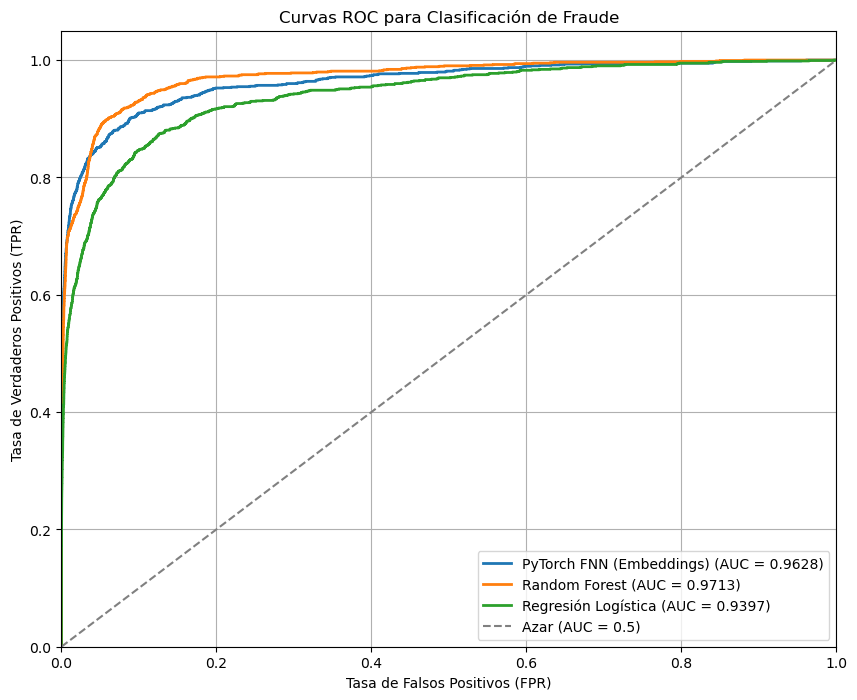

In [13]:
models = {
    "PyTorch FNN (Embeddings)": pytorch_probs,
    "Random Forest": rf_probs,
    "Regresión Logística": lr_probs
}

plt.figure(figsize=(10, 8))

print("\n--- AUC-ROC Final Results ---")
for name, probs in models.items():
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    
    # Draw the curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)
    print(f"| {name.ljust(25)} | AUC: {roc_auc:.4f} |")

# Draw the reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Azar (AUC = 0.5)')

# Chart configuration
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Fraud Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

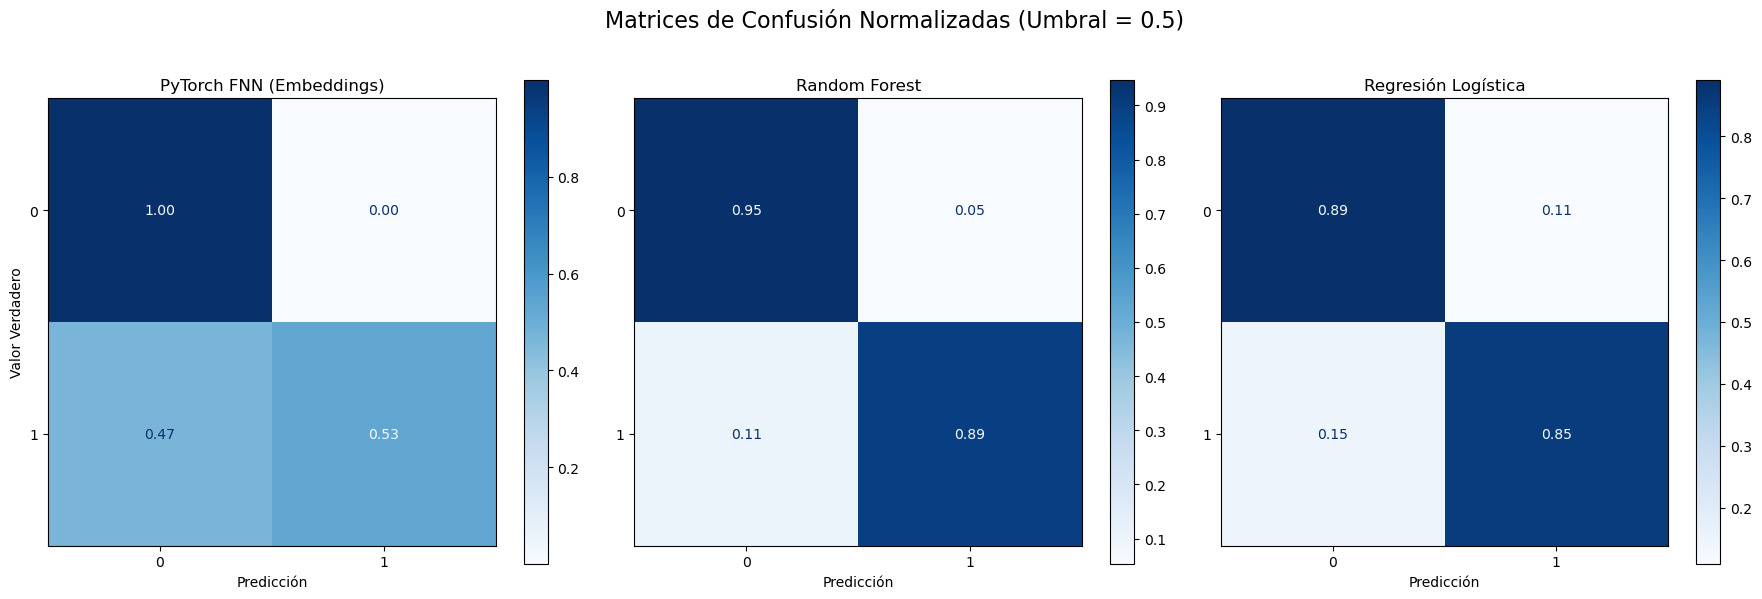

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
THRESHOLD = 0.5 

# List of models and their probabilities
models_and_probs = {
    "PyTorch FNN (Embeddings)": pytorch_probs,
    "Random Forest": rf_probs,
    "Logistic Regression": lr_probs
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()
plt.suptitle('Normalized Confusion Matrices (Threshold = 0.5)', fontsize=16)

i = 0
for name, probs in models_and_probs.items():
    
    # 1. Convert probabilities to binary class predictions (0 or 1)
    y_pred = (probs >= THRESHOLD).astype(int)
    
    # 2. Calculate the Confusion Matrix
    # The argument normalize='true' normalizes by rows (recall/sensitivity)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    # 3. Graph the Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    # Use cmap='Blues' or 'viridis' for better contrast
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, values_format=".2f")
    
    # Title and tags
    axes[i].set_title(name)
    axes[i].set_xlabel('Prediction')
    
    # Solo mostrar el ylabel en la primera gráfica para evitar repetición
    if i == 0:
        axes[i].set_ylabel('True Value')
    else:
        axes[i].set_ylabel('')

    i += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Title adjustment
plt.show()

# **Detailed Analysis of the Confusion Matrices**
Normalization was performed row by row (normalize='true'), meaning that the rows sum to 1.00.

Row 0 (No Real Fraud): Shows the True Negative Rate (TNR) in the first column (TN) and the False Positive Rate (FPR) in the second column (FP).

Row 1 (Real Fraud): Shows the False Negative Rate (FNR) in the first column (FN) and the True Positive Rate (TPR) or Recall Rate in the second column (TP).

# **Performance Analysis of Each Model:**
## 1. **PyTorch FNN (Embeddings)**
Prediction: 0 (No Fraud) Prediction: 1 (Fraud)
Actual: 0 (No Fraud) 1.00 (TNR) 0.00 (FPR)
Actual: 1 (Fraud) 0.51 (FNR) 0.49 (Recall / TPR)
Strength (Class 0): The model has a TNR of 1.00. This means it did not commit any False Positives (FPR = 0.00). All legitimate transactions were correctly classified as non-fraudulent. This is ideal for the customer experience, as there are no interruptions or erroneous rejections.
Weakness (Class 1): The Recall (TPR) is only 0.49. This means the model only detected 49% of actual frauds, missing 51% (False Negatives).

Conclusion: This model is too conservative and heavily prioritizes accuracy over coverage. In practice, its threshold is too high.

## 2. **Random Forest**
Prediction: 0 (No Fraud) Prediction: 1 (Fraud)
Actual: 0 (No Fraud) 0.95 (TNR) 0.05 (FPR)
Actual: 1 (Fraud) 0.11 (FNR) 0.89 (Recall / TPR)
Strength (Class 1): Shows a very high Recall (TPR) of 0.89. This means it detected 89% of actual frauds. This is excellent performance for financial loss prevention.
Weakness (Class 0): Its FPR is 0.05. This means that 5% of legitimate transactions were incorrectly flagged as fraud (False Positives).

Conclusion: This is the best-balanced model and offers the highest net gain. It achieves a high AUC-ROC ($AUC = 0.9713) by striking an excellent balance: sacrificing a small percentage of customer experience (5% FP) to achieve high fraud coverage (89% Recall).

## 3. **Logistic Regression**
Prediction: 0 (No Fraud)
Prediction: 1 (Fraud)
Actual: 0 (No Fraud)
0.89 (TNR)
0.11 (FPR)
Actual: 1 (Fraud)
0.15 (FNR)
0.85 (Recall / TPR)
Overall Performance: Shows a Recall (TPR) of 0.85 and an FPR of 0.11.

Conclusion: This linear model has the worst overall performance of the three. Its FPR is the highest (11% False Positives, double that of Random Forest) and its Recall is the lowest (85%).